## 목적
- avg_subscription_period 값 오류 체크

## Package

In [1]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive
from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [3]:
RESULT_PATH = '/home/dmig/work/upsell/result/summary'

## Load data

In [4]:
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))
df_mart02 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201902.pkl'))
df_mart03 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201903.pkl'))
df_mart04 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201904.pkl'))
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

df_input06 = pd.read_pickle(os.path.join(DATA_PATH, 'df_input_201906.pkl'))

In [5]:
df_mart01.shape, df_mart02.shape, df_mart03.shape, df_mart04.shape, df_mart05.shape, df_input06.shape

((18176215, 81),
 (18462905, 81),
 (18580984, 81),
 (18626176, 81),
 (18707537, 81),
 (18855464, 80))

In [8]:
df_dict = {
    '01': df_mart01, 
    '02': df_mart02, 
    '03': df_mart03, 
    '04': df_mart04, 
    '05': df_mart05, 
    '06': df_input06
}

## diff_svc_scrb_avg_scrb
- svc_scrb_period(가입기간) - avg_subscription_period(평균 요금제 변경 기간)

In [7]:
for month, df in df_dict.items():
    df['diff_svc_scrb_avg_scrb'] = df['svc_scrb_period'] - df['avg_subscription_period']

In [60]:
col = 'diff_svc_scrb_avg_scrb'

month:  01



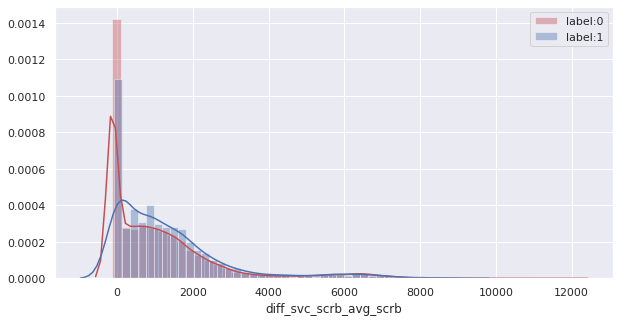

month:  02



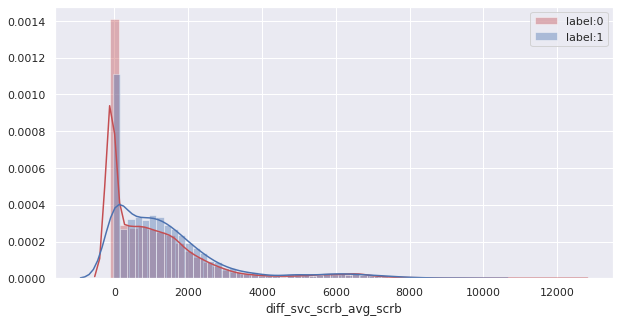

month:  03



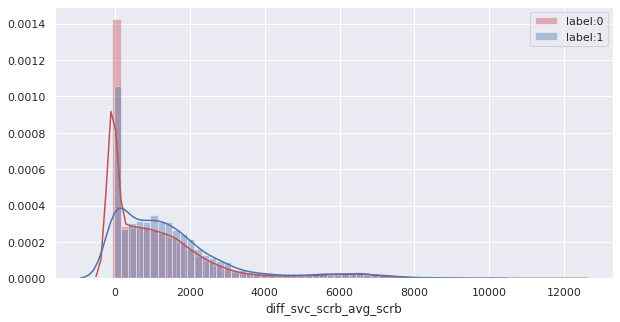

month:  04



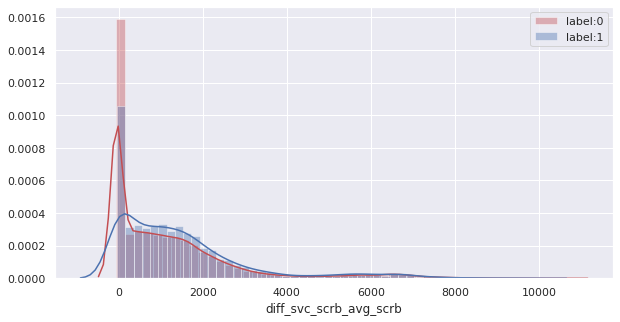

month:  05



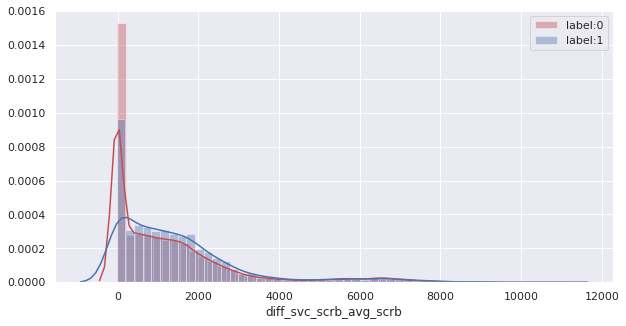

In [69]:
for month, df in df_dict.items():
    if month == '06': break    
    print('='*50)
    print('month: ', month)
    print('')
    df_tmp = df.sample(frac=0.01)
    sns.set(rc={'figure.figsize': (10,5)})
    sns.distplot(df_tmp[df_tmp.label==0][col], color='r', label='label:0')
    sns.distplot(df_tmp[df_tmp.label==1][col], color='b', label='label:1')
    plt.legend()
    plt.show()

In [16]:
for month, df in df_dict.items():
    print('-'*20)
    print('month: ', month)
    
    min_value = df['diff_svc_scrb_avg_scrb'].min()
    print('min value of diff_svc_scrb_avg_scrb: ', min_value)
    print('customer counts have min value: ', df[df['diff_svc_scrb_avg_scrb']==min_value].shape[0] )
    print('')

--------------------
month:  01
min value of diff_svc_scrb_avg_scrb:  -143.0
customer counts have min value:  4755315

--------------------
month:  02
min value of diff_svc_scrb_avg_scrb:  -115.0
customer counts have min value:  4956511

--------------------
month:  03
min value of diff_svc_scrb_avg_scrb:  -85.0
customer counts have min value:  5185383

--------------------
month:  04
min value of diff_svc_scrb_avg_scrb:  -55.0
customer counts have min value:  5377548

--------------------
month:  05
min value of diff_svc_scrb_avg_scrb:  -24.0
customer counts have min value:  5568878

--------------------
month:  06
min value of diff_svc_scrb_avg_scrb:  1.0
customer counts have min value:  5695578



## 결과 분석
- 애초에 avg_subscription_period(평균값)은 svc_scrb_period(서비스 가입기간) 보다 클 수 없음
- 동일한 minus 값을 갖는 고객 수가 500~550 만명
- change_fee_history 테이블은 매일매일 update 됨
- 현재 sql 상, 요금제 변경을 한 번도 하지 않은 고객은 svc_scrb_perio 값은 ym을 기준으로 고정되지만 avg_subscription_period는 매일 +1이 됨

#### svc_scrb_period

In [19]:
svc_scrb_period_sql = """
datediff(from_unixtime(unix_timestamp('{{ ds_nodash_add(ds_nodash, -1) }}','yyyyMMdd'),'yyyy-MM-dd'),
from_unixtime(unix_timestamp(svc_scrb_dt,'yyyyMMdd'),'yyyy-MM-dd')) AS svc_scrb_period 
from comm.user_profile_monthly
"""

#### avg_subscription_period

In [20]:
avg_subscription_period_sql = """
INSERT OVERWRITE TABLE {{ var.json.databases.comm }}.user_profile_monthly partition (ym='{{ ym_nodash_add_month(ds_nodash, 0) }}', dimension='avg_subscription_period')
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        {{ var.json.databases.comm }}.change_fee_history
WHERE       scrb_dt <= '{{ ds_nodash }}'
GROUP BY    svc_mgmt_num 
;
"""

In [27]:
df_mart04[df_mart04.diff_svc_scrb_avg_scrb==-55].head()[['svc_mgmt_num', 'svc_scrb_period', 
                                                         'avg_subscription_period', 'diff_svc_scrb_avg_scrb']]

svc_mgmt_num  svc_scrb_period  avg_subscription_period  \
1270   7002551488             4479                   4534.0   
1559   7017072457             3975                   4030.0   
1577   7017777059             3958                   4013.0   
1662   7020910826             3844                   3899.0   
1709   7022821375             3767                   3822.0   

      diff_svc_scrb_avg_scrb  
1270                   -55.0  
1559                   -55.0  
1577                   -55.0  
1662                   -55.0  
1709                   -55.0

In [33]:
sql = """
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        comm.change_fee_history
WHERE       scrb_dt <= '20190430'
and         svc_mgmt_num = '7002551488'
GROUP BY    svc_mgmt_num 
"""

In [34]:
conn = hive_connection('dmig')
df = load_from_hive(conn, sql)

2019-07-29 09:42:50,448 - YE_HIVE - INFO - ...tmp_db name = tmp_20190729_09_42_50_eefd5e730d6b8daeebfe225732308c85cc7f61de
2019-07-29 09:42:50,450 - YE_HIVE - INFO - Start creating table
2019-07-29 09:42:50,450 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190729_09_42_50_eefd5e730d6b8daeebfe225732308c85cc7f61de
2019-07-29 09:42:50,491 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190729_09_42_50_eefd5e730d6b8daeebfe225732308c85cc7f61de' is done
2019-07-29 09:43:07,533 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190729_09_42_50_eefd5e730d6b8daeebfe225732308c85cc7f61de 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        comm.change_fee_history
WHERE       scrb_dt <= '20190430'
and         svc_mgm

In [35]:
df

svc_mgmt_num   value
0   7002551488  4567.0

In [44]:
sql2 = """
SELECT      svc_mgmt_num
,           datediff(from_unixtime(unix_timestamp('20190625','yyyyMMdd'),'yyyy-MM-dd'),
            from_unixtime(unix_timestamp(scrb_dt,'yyyyMMdd'),'yyyy-MM-dd')) AS test_value 
FROM        comm.change_fee_history
WHERE       scrb_dt <= '20190430'
and         svc_mgmt_num = '7002551488'
and         current_prod_yn = 'Y' 
"""

In [45]:
conn = hive_connection('dmig')
df2 = load_from_hive(conn, sql2)

2019-07-29 09:49:37,857 - YE_HIVE - INFO - ...tmp_db name = tmp_20190729_09_49_37_965b2480114b2e3174bba7ee7eff95e0c72108a2
2019-07-29 09:49:37,858 - YE_HIVE - INFO - Start creating table
2019-07-29 09:49:37,859 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190729_09_49_37_965b2480114b2e3174bba7ee7eff95e0c72108a2
2019-07-29 09:49:37,902 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190729_09_49_37_965b2480114b2e3174bba7ee7eff95e0c72108a2' is done
2019-07-29 09:49:58,682 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190729_09_49_37_965b2480114b2e3174bba7ee7eff95e0c72108a2 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
SELECT      svc_mgmt_num
,           datediff(from_unixtime(unix_timestamp('20190625','yyyyMMdd'),'yyyy-MM-dd'),
            from_unixtime(unix_timestamp(scrb_dt

In [46]:
df2

svc_mgmt_num  test_value
0   7002551488        4535

month:  01



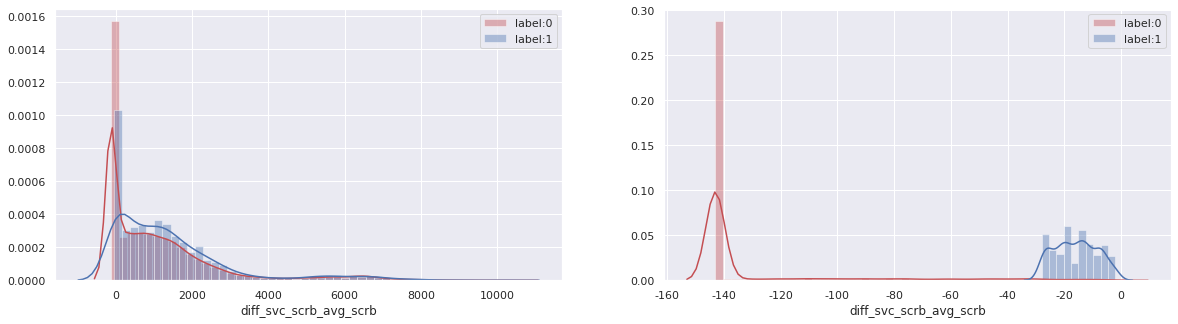

month:  02



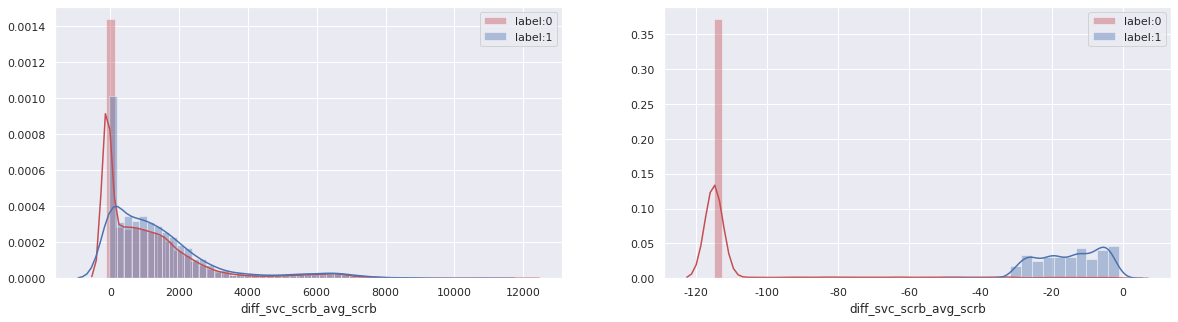

month:  03



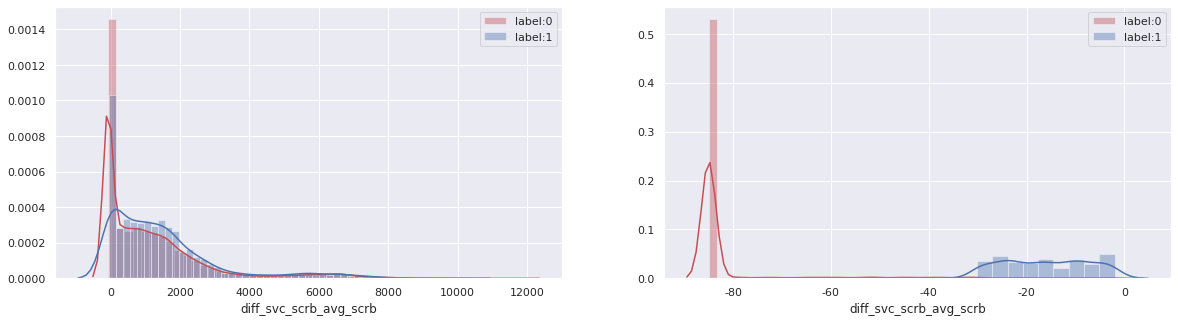

month:  04



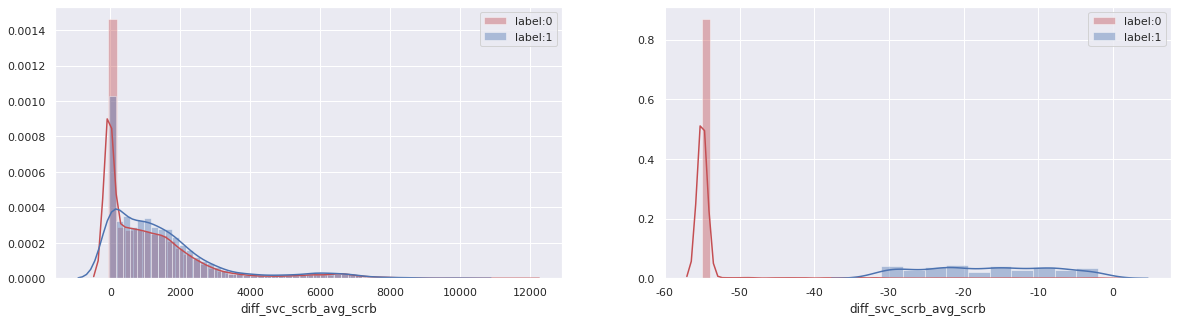

month:  05



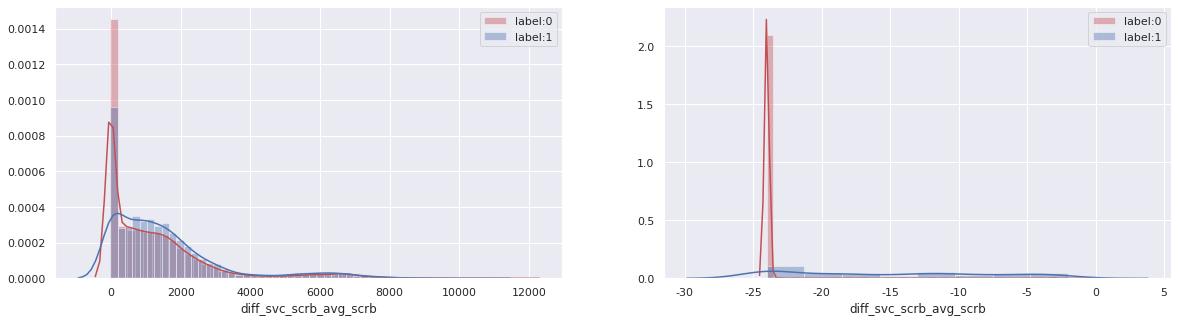

In [68]:
for month, df in df_dict.items():
    if month == '06':
        break
    print('='*100)
    print('month: ', month)
    print('')
    df_tmp = df.sample(frac=0.01)
    df_minus = df[df.diff_svc_scrb_avg_scrb<0].sample(frac=0.01)
    sns.set(rc={'figure.figsize': (20,5)})
    plt.subplot(1,2,1)
    sns.distplot(df_tmp[df_tmp.label==0][col], color='r', label='label:0')
    sns.distplot(df_tmp[df_tmp.label==1][col], color='b', label='label:1')
    plt.legend()
    plt.subplot(1,2,2)
    sns.distplot(df_minus[df_minus.label==0][col], color='r', label='label:0')
    sns.distplot(df_minus[df_minus.label==1][col], color='b', label='label:1')
    plt.legend()
    plt.show()

## 결과 분석
- 기준 월(ym)부터 6/25일까지 유지한 고객이 -140, -55 등의 min 값을 가짐
- 이 값을 갖는 고객들은 전부 label값이 0
- 6월의 정보가 기준월(1,2,3,4,5)에 들어간 상태 -> 후행변수
- 때문에 기존에 svc_scrb_period, avg_subscription_period의 영향을 overfitting 했던 lgb나 xgb의 성능이 train, valid에서는 좋고 test에서는(특히 기간이 많이 차이나는) 매우 안좋게 나옴

## 해결 방안
- avg_subsription_period sql 수정
- 변경 사항: 현재 고객의 요금제는 average 계산 시 반영하지 않음

#### example. 4월 기준 sql 

In [70]:
sql2 = """
select  a.svc_mgmt_num
,       nvl(b.value, -9999) as value
from    comm.user_input_matrix_for_upsell_monthly a
left join(
    select  svc_mgmt_num, 
            avg(subscription_period) as value 
    from    comm.change_fee_history
    where   term_dt <= '20190430'
    and     subscription_period > 10
    group by svc_mgmt_num
) b on a.svc_mgmt_num = b.svc_mgmt_num
where   ym = '201904'
;
"""

In [71]:
tmp_sql = """
select svc_mgmt_num, scrb_dt, term_dt, seq_prod, subscription_period
from comm.change_fee_history
where svc_mgmt_num = '7293403831'
"""

In [72]:
conn = hive_connection('dmig')
tmp_df = load_from_hive(conn, tmp_sql)

2019-07-29 10:21:59,497 - YE_HIVE - INFO - ...tmp_db name = tmp_20190729_10_21_59_d64373687a7f98ddf4d4fe7416644bbd615f0104
2019-07-29 10:21:59,498 - YE_HIVE - INFO - Start creating table
2019-07-29 10:21:59,498 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190729_10_21_59_d64373687a7f98ddf4d4fe7416644bbd615f0104
2019-07-29 10:21:59,544 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190729_10_21_59_d64373687a7f98ddf4d4fe7416644bbd615f0104' is done
2019-07-29 10:22:20,993 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190729_10_21_59_d64373687a7f98ddf4d4fe7416644bbd615f0104 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select svc_mgmt_num, scrb_dt, term_dt, seq_prod, subscription_period
from comm.change_fee_history
where svc_mgmt_num = '7293403831'
' is done
2019-07-29 10:22:21

In [73]:
tmp_df

svc_mgmt_num   scrb_dt   term_dt seq_prod subscription_period
0   7293403831  20180731  20190201        2                 185
0   7293403831  20190201  99991231        1                 176

In [8]:
base_sql = """
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        comm.change_fee_history
WHERE       scrb_dt <= '20190430'
and         svc_mgmt_num = '7293403831'
GROUP BY    svc_mgmt_num 
"""

In [9]:
conn = hive_connection('dmig')
base_df = load_from_hive(conn, base_sql)

2019-07-29 10:35:11,931 - YE_HIVE - INFO - ...tmp_db name = tmp_20190729_10_35_11_3614fe701a49682a6a5e580734593329660c8a7b
2019-07-29 10:35:11,933 - YE_HIVE - INFO - Start creating table
2019-07-29 10:35:11,934 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190729_10_35_11_3614fe701a49682a6a5e580734593329660c8a7b
2019-07-29 10:35:11,979 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190729_10_35_11_3614fe701a49682a6a5e580734593329660c8a7b' is done
2019-07-29 10:35:36,843 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190729_10_35_11_3614fe701a49682a6a5e580734593329660c8a7b 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        comm.change_fee_history
WHERE       scrb_dt <= '20190430'
and         svc_mgm

In [10]:
base_df

svc_mgmt_num  value
0   7293403831  180.5

In [11]:
new_sql = """
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        comm.change_fee_history
WHERE       term_dt <= '20190430'
and         svc_mgmt_num = '7293403831'
GROUP BY    svc_mgmt_num 
"""

In [12]:
conn = hive_connection('dmig')
new_df = load_from_hive(conn, new_sql)

2019-07-29 10:36:27,128 - YE_HIVE - INFO - ...tmp_db name = tmp_20190729_10_36_27_e0b1f3d7c58901e33f55651e0a901fd938572825
2019-07-29 10:36:27,130 - YE_HIVE - INFO - Start creating table
2019-07-29 10:36:27,131 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20190729_10_36_27_e0b1f3d7c58901e33f55651e0a901fd938572825
2019-07-29 10:36:27,178 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20190729_10_36_27_e0b1f3d7c58901e33f55651e0a901fd938572825' is done
2019-07-29 10:36:46,875 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20190729_10_36_27_e0b1f3d7c58901e33f55651e0a901fd938572825 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
SELECT      svc_mgmt_num
,           avg(subscription_period) as value 
FROM        comm.change_fee_history
WHERE       term_dt <= '20190430'
and         svc_mgm

In [13]:
new_df

svc_mgmt_num  value
0   7293403831  185.0